In [53]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import cv2
import os
import matplotlib.pyplot as plt

def load_image(image_path):
    image = cv2.imread(image_path)
    return image

def load_support_set(folder_path):
    support_set = []
    # Iterate over the images in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        support_set.append(image)
    return support_set

def display_image(image):
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")
    plt.show()

def preprocess_image(image):
    # Resize the image to the desired dimensions
    resized_image = cv2.resize(image, (28, 28))

    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Normalize the pixel values to [0, 1]
    normalized_image = grayscale_image.astype("float32") / 255.0

    # Reshape the image to match the input shape expected by the Siamese network
    reshaped_image = np.reshape(normalized_image, (28, 28, 1))

    return reshaped_image

def preprocess_support_set(support_set):
    preprocessed_images = []
    for image in support_set:
        preprocessed_image = preprocess_image(image)
        preprocessed_images.append(preprocessed_image)
    return np.array(preprocessed_images)





In [54]:
 #Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize and reshape the input data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

# Generate pairs of input data
def generate_pairs(x, y, num_classes):
    pairs = []
    labels = []
    num_samples = len(x)

    for i in range(num_samples):
        current_image = x[i]
        current_label = y[i]
        other_indices = np.where(y == current_label)[0]

        positive_index = np.random.choice(other_indices)
        negative_index = np.random.choice(np.where(y != current_label)[0])

        pairs.append([current_image, x[positive_index]])
        labels.append(1)  # 1 indicates positive pair
        pairs.append([current_image, x[negative_index]])
        labels.append(0)  # 0 indicates negative pair

    return np.array(pairs), np.array(labels)

# Generate training and validation pairs
train_pairs, train_labels = generate_pairs(x_train, y_train, num_classes=10)
val_pairs, val_labels = generate_pairs(x_test, y_test, num_classes=10)

# Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = keras.Input(shape=input_shape)
    input_2 = keras.Input(shape=input_shape)

    # Shared convolutional base
    conv_base = keras.Sequential(
        [
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
        ]
    )

    # Process the two inputs
    processed_1 = conv_base(input_1)
    processed_2 = conv_base(input_2)

    # Calculate Euclidean distance between the processed inputs
    distance = K.sqrt(K.sum(K.square(processed_1 - processed_2), axis=1, keepdims=True))

    # Siamese network model
    model = Model(inputs=[input_1, input_2], outputs=distance)
    return model


In [55]:

# Create the Siamese network
siamese_network = create_siamese_network(input_shape=(28, 28, 1))

# Compile the model
siamese_network.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
history = siamese_network.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, batch_size=64, epochs=10,
                    validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

# Evaluate the model
test_loss, test_accuracy = siamese_network.evaluate([val_pairs[:, 0], val_pairs[:, 1]], val_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



Epoch 1/10
1875/1875 [==============================] - 142s 75ms/step - loss: 0.7305 - accuracy: 0.4927 - val_loss: 0.7258 - val_accuracy: 0.5063
Epoch 2/10
1875/1875 [==============================] - 139s 74ms/step - loss: 0.7077 - accuracy: 0.5174 - val_loss: 0.7191 - val_accuracy: 0.5071
Epoch 3/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.6957 - accuracy: 0.5370 - val_loss: 0.7189 - val_accuracy: 0.4980
Epoch 4/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.6859 - accuracy: 0.5548 - val_loss: 0.7209 - val_accuracy: 0.5012
Epoch 5/10
1875/1875 [==============================] - 133s 71ms/step - loss: 0.6776 - accuracy: 0.5757 - val_loss: 0.7173 - val_accuracy: 0.5023
Epoch 6/10
1875/1875 [==============================] - 134s 71ms/step - loss: 0.6689 - accuracy: 0.5941 - val_loss: 0.7208 - val_accuracy: 0.5003
Epoch 7/10
1875/1875 [==============================] - 133s 71ms/step - loss: 0.6623 - accuracy: 0.6092 - val_loss: 0

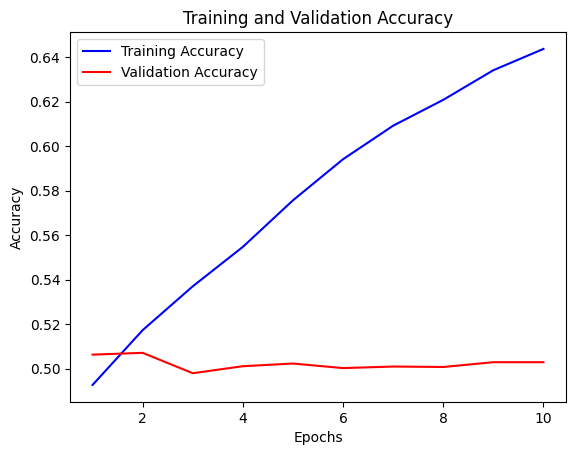

In [56]:
# Access the accuracy values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy graph
epochs = range(1, len(train_accuracy) + 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [77]:
! rm -rf drive/

In [78]:
# Mounting the google drive to google colab in order to load the data files directly from it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 0s 28ms/step


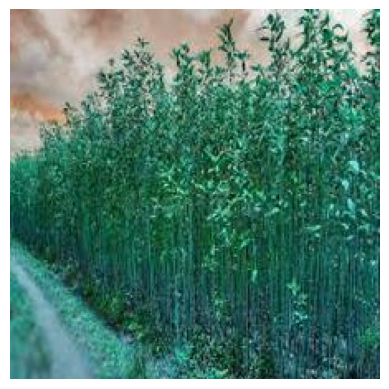

In [80]:
# Load the query image
query_image = load_image('/content/drive/MyDrive/Action_Learning/query/jute.jpg')

# Load the support set
support_set = load_support_set('/content/drive/MyDrive/Action_Learning/support_set')

# Preprocess the query image
query_image = preprocess_image(query_image)

# Preprocess the support set
support_set = preprocess_support_set(support_set)

# Compute feature representations for the query image
query_features = siamese_network.predict([np.expand_dims(query_image, axis=0), np.expand_dims(query_image, axis=0)])

# Compute feature representations for the support set
support_features = siamese_network.predict([support_set, support_set])

# Calculate distances
distances = np.linalg.norm(query_features - support_features, axis=1)  # Euclidean distance

# Perform ranking or classification
#sorted_indices = np.argsort(distances)
#ranked_support_set = support_set[sorted_indices]

# Display or use the top-k closest images
#top_k = 5
#top_k_images = ranked_support_set[:top_k]
#for image in top_k_images:
#    display_image(image)



# Find the index of the most similar image
most_similar_index = np.argmin(distances)

# Load and display the most similar image from the support set
most_similar_image_path = os.path.join('/content/drive/MyDrive/Action_Learning/support_set', os.listdir('/content/drive/MyDrive/Action_Learning/support_set')[most_similar_index])
most_similar_image = load_image(most_similar_image_path)
display_image(most_similar_image)
